In [16]:
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths
DATA_DIR = Path("..") / "data"
RAW_CSV = DATA_DIR / "starter_data.csv"
PROC_DIR = DATA_DIR / "processed"
FIG_DIR = Path("..") / "figures"
SRC_DIR = Path("..") / "src"

# Ensure folders exist
for p in [DATA_DIR, PROC_DIR, FIG_DIR, SRC_DIR]:
    p.mkdir(parents=True, exist_ok=True)


# NumPy Operations (vectorized vs loop)

In [17]:
# Create a NumPy array
arr = np.arange(1_000_00)  # 100k for quick runtime; raise to 1_000_000 if you like

# Vectorized
t0 = time.time()
vec = arr * 2
t1 = time.time()

# Python loop (list comprehension)
t2 = time.time()
loop = [x * 2 for x in arr]
t3 = time.time()

print(f"Vectorized time: {t1 - t0:.6f} s")
print(f"Loop time      : {t3 - t2:.6f} s")
print("Same result?   :", np.array_equal(vec, loop))


Vectorized time: 0.000433 s
Loop time      : 0.014736 s
Same result?   : True


# Load Dataset & Inspect

In [18]:
# If starter_data.csv is missing, create a small demo dataset so the notebook still runs
if not RAW_CSV.exists():
    demo = pd.DataFrame({
        "category": np.random.choice(list("ABC"), size=200),
        "value": np.random.normal(loc=10, scale=3, size=200).round(3),
        "amount": np.random.gamma(shape=2.0, scale=5.0, size=200).round(3)
    })
    demo.to_csv(RAW_CSV, index=False)
    print(f"[Info] Created demo dataset at {RAW_CSV}")

# Load
df = pd.read_csv(RAW_CSV)

# Inspect
display(df.head())
print("\n.info():")
print(df.info())

,category,value,date
0,A,10,2025-08-01
1,B,15,2025-08-02
2,A,12,2025-08-03
3,B,18,2025-08-04
4,C,25,2025-08-05



.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  10 non-null     object
 1   value     10 non-null     int64 
 2   date      10 non-null     object
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes
None


# Summary Stats & GroupBy

In [19]:
# Numeric summary
numeric_summary = df.describe()  # numeric-only by default
display(numeric_summary)

# Pick a grouping column (prefer a non-numeric column if available)
non_numeric_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
if len(non_numeric_cols) == 0:
    # If no categorical column exists, create one by binning the first numeric column
    num_cols = df.select_dtypes(include="number").columns.tolist()
    if not num_cols:
        raise ValueError("No numeric columns found to create a grouping.")
    cut_col = num_cols[0]
    df["category_auto"] = pd.qcut(df[cut_col], q=3, labels=["low", "mid", "high"])
    group_col = "category_auto"
else:
    group_col = non_numeric_cols[0]

# GroupBy aggregation (mean of numeric columns by chosen category)
group_summary = df.groupby(group_col).mean(numeric_only=True)
display(group_summary)
print(f"Grouped by: {group_col!r}")


,value
count,10.000000
mean,17.600000
std,7.381659
min,10.000000
25%,12.250000
50%,14.500000
75%,23.250000
max,30.000000


,value
category,
A,11.500000
B,15.666667
C,27.666667


Grouped by: 'category'


# Save Outputs (CSV/JSON) + Simple Plot

Saved: ../data/processed/summary.csv
Saved: ../data/processed/summary.json
Saved: ../data/processed/groupby_category.csv


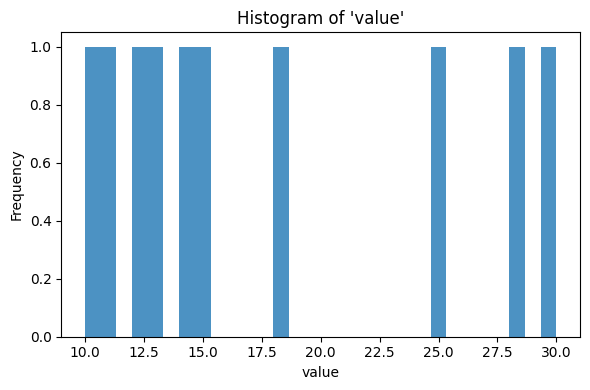

Saved plot: ../figures/hist_value.png


In [20]:
# Save numeric summary
summary_csv = PROC_DIR / "summary.csv"
summary_json = PROC_DIR / "summary.json"
numeric_summary.to_csv(summary_csv)
numeric_summary.to_json(summary_json, orient="table")  # structured JSON

# Also save groupby result
group_csv = PROC_DIR / f"groupby_{group_col}.csv"
group_summary.to_csv(group_csv)

print(f"Saved: {summary_csv}")
print(f"Saved: {summary_json}")
print(f"Saved: {group_csv}")

# Bonus: simple plot — histogram of the first numeric column
num_cols = df.select_dtypes(include="number").columns.tolist()
if num_cols:
    col = num_cols[0]
    plt.figure(figsize=(6,4))
    df[col].plot(kind="hist", bins=30, alpha=0.8, title=f"Histogram of '{col}'")
    plt.xlabel(col)
    fig_path = FIG_DIR / f"hist_{col}.png"
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print(f"Saved plot: {fig_path}")
else:
    print("No numeric columns to plot.")


# Reusable Functions (in-notebook)

In [21]:
def get_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return summary stats for numeric columns.
    """
    return df.describe()

def groupby_numeric_means(df: pd.DataFrame, by: str) -> pd.DataFrame:
    """
    Group by 'by' and compute means of numeric columns.
    """
    if by not in df.columns:
        raise KeyError(f"Group column '{by}' not found in DataFrame.")
    return df.groupby(by).mean(numeric_only=True)

# Use the functions
stats2 = get_summary_stats(df)
group2 = groupby_numeric_means(df, by=group_col)

display(stats2)
display(group2)


,value
count,10.000000
mean,17.600000
std,7.381659
min,10.000000
25%,12.250000
50%,14.500000
75%,23.250000
max,30.000000


,value
category,
A,11.500000
B,15.666667
C,27.666667


# Bonus — Move utilities to src/utils.py and import
file generator

In [15]:
utils_code = """\
import pandas as pd

def get_summary_stats(df: pd.DataFrame) -> pd.DataFrame:
    return df.describe()

def groupby_numeric_means(df: pd.DataFrame, by: str) -> pd.DataFrame:
    if by not in df.columns:
        raise KeyError(f"Group column '{by}' not found in DataFrame.")
    return df.groupby(by).mean(numeric_only=True)
"""

(SRC_DIR / "utils.py").write_text(utils_code, encoding="utf-8")
print("Wrote src/utils.py")


Wrote src/utils.py
